In [ ]:
import pandas as pd
import numpy as np
import glob
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from google.colab import drive
import matplotlib.pyplot as plt
import math 

# REQUIRES: Dataframe has an even number of cols, and column of interest is at every even column
# EFFECT: Drops all odd columns in a dataframe
def drop_odd_cols(dataframe):
  df = dataframe
  col_drop_list = []
  for i,col in enumerate(df.columns): 
    if(i % 2 == 0):
      col_drop_list.append(col)
  df = df.drop(col_drop_list,axis = 1)
  return df

def drop_first_col(dataframe):
  dataframe.pop(dataframe.columns[0])

#REQUIRES: Fraction is between 0-1 inclusive, elements in array are np_arrays
#EFFECT: Splits an array of np_arrays into 2 parts depending on value of fraction, e.g. fraction = 0.3 means arr1 is 70% & arr2 is 30% of np_array
def split_array(fraction, array):
  arr1 = [] #longer array 
  arr2 = []
  for i in range(len(array)):
    length = len(array[i])
    num_split = round(length * fraction)
    #array_split returns an array containing 3 elements [[null],[small np],[big np]]
    split = np.array_split(array[i], [0,num_split])
    arr1.append(split[2])
    arr2.append(split[1])
  return arr1, arr2

# REQUIRES: Folder path must be 1 directories above .xlsx files ({INPUT_PATH} -- > xlsx files)
# EFFECT: Reads all xlsx files in a folder and returns a 3D numpy array (batch_size, x,y) with data stacked along new axis (axis = 0)
def excel_reader(folder_path, drop_alternate = False, drop_first = False): 
    files = glob.glob(folder_path + "/*.xlsx")
    df_list = []
    for file in files:
        df = pd.read_excel(file)
        if drop_alternate:
          df = drop_odd_cols(df)
        if drop_first:
          drop_first_col(df)
        df_list.append(df)
    np_array = np.array(list(map(lambda x: x.to_numpy(), df_list)))
    np_array = np_array.reshape((len(df_list), len(df.axes[0]), len(df.axes[1])))
    return np_array

# EFFECT: Returns list of non-hidden folders & files present in a directory 
def listdir_non_hidden(folder_path): 
    folders = []
    for folder in os.listdir(folder_path):
        if not folder.startswith('.'):
            folders.append(folder)
    return folders

# REQUIRES: x,y,z be not empty
# EEFECT: generate model structure based on input shape of x,y,z
def create_model(choices, x,y,z):
  model = tf.keras.Sequential([
      layers.Conv2D(32, (3, 3), padding = "SAME", activation='relu', input_shape=(x,y,z)),
      layers.AveragePooling2D((2, 2)),
      layers.Conv2D(64, (3, 3), padding = "SAME", activation='relu'),
      layers.AveragePooling2D((2, 2)),
      layers.Conv2D(64, (3, 3), padding = "SAME", activation='relu'),
      layers.AveragePooling2D((2, 2)),
      layers.Flatten(),
      layers.Dense(100, activation = 'relu'),
      layers.Dropout(0.03),
      layers.Dense(100, activation = 'relu'),
      layers.Dense(50, activation = 'relu'),
      layers.Dense(len(choices)),
      layers.Softmax()])

  model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
      
  return model


# REQUIRES: Model weights in folder must match current model architecture
# EFFECT: Load a model from its saved weights
def load_model(path,x,y,z,choices):
  model = create_model(choices,x,y,z)
  model.load_weights(path)
  return model

# REQUIRES: - Maximum and minimum values are more than and less than 0 respectively 
#           - Folder path must be 2 directories above .xlsx files ({INPUT_PATH} -- > categories -- > xlsx files)
#           - fraction must be 0-1 inclusive
# EFFECT: Summarizes data of xslx files in a folder by returning four items: 
#         1. (1-fraction) of array whose elements are numpy datas corresponding to categories (e.g. [np1,np2,np3] )
#         2. remaining fraction amount of array in (3)
#         3. maximum value
#         4. minimum value
#         5. folder categories
def summarize(path, drop_alternate = False, drop_first = False):
  folders = listdir_non_hidden(path)
  max_val = 0
  min_val = 0
  datas = []
  for folder in folders:
    data = excel_reader(path + folder, drop_alternate = drop_alternate, drop_first = drop_first)
    current_max = data.max()
    current_min = data.min()
    if(max_val < current_max):
      max_val = current_max
    if(min_val > current_min):
      min_val = current_min
    datas.append(data)
  return datas, max_val, min_val, folders

def normalize(data,min_val,max_val):
  return((data - min_val) / (max_val - min_val))

# REQUIRES: Index >= 0, predictions is a 2D array and >= 3 along axis = 0, and choices reflect number of output nodes for model & are accurate in name
# EFFECT: Prints top 3 predictions for a given data with their respective probabilities
def predict_top_three(index, predictions, choices):
  prediction = []
  for i in range(len(predictions[index])):
    prediction.append(predictions[index][i])
  prediction = np.asarray(prediction)
  ranks = []
  for i in range(3):
    current_index = np.argmax(prediction)
    ranks.append(current_index)
    prediction[current_index] = 0
  print("The top three predictions are:")
  print("1.", choices[ranks[0]], "with probability of", predictions[index][ranks[0]])
  print("2.", choices[ranks[1]], "with probability of", predictions[index][ranks[1]])
  print("3.", choices[ranks[2]], "with probability of", predictions[index][ranks[2]])
  print()
  return

# REQUIRES: start_index, num_terms > 0, predictions is a 2D array and >= 3 along axis = 0, and choices reflect number of output nodes for model
# EFFECT: Prints top prediction for a given range (start-end)
def predict_top_three_multiple(start_index,num_terms, predictions,choices):
  range_predictions = predictions[start_index:start_index + num_terms]
  for i in range(num_terms):
    print("Data index (", i + start_index, ")")
    predict_top_three(i,range_predictions,choices)
  return

# REQUIRES: Index >= 0, data is a 4D array, predictions is a 2D array, choices reflect number of nodes of output, category is 1D array containing names of experimental categories, data is normalized
# EFFECT: Display a summary of a specific experimental data using a bar graph
def display_predictions(index, data, predictions, choices, category, category_index, min_val, max_val): 
    fig, ax = plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 3]}, figsize=(25,10))
    # first subplot
    im = ax[0].imshow(data[index,:,:,0], aspect = 'auto', cmap = 'bwr', vmin = 0, vmax = 1)
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[0].set_title(f"Data({index}) from category: {category[category_index[index]]}", size = 20)
    range_of_vals = np.round_(np.linspace(min_val, max_val, 6),6)
    normalized = np.linspace(0,1,6)
    cbar = plt.colorbar(im, ax=ax[0], ticks = normalized)
    cbar.ax.set_yticklabels(range_of_vals)
    for i in range(7):
      print(choices[i])


    # second subplot 
    thisplot = ax[1].bar(range(len(choices)), predictions[index], color="#FFCCCB")
    ax[1].set_xticks(range(len(choices)))
    ax[1].set_yticks([])
    ax[1].set_ylim([0,1])
    predicted_label = np.argmax(predictions[index])
    thisplot[predicted_label].set_color('#90EE90')
    ax[1].set_title(f"Predicted Category: {choices[predicted_label]} ({predicted_label} on graph)", size = 20)
    # to label each bar with percentage on top   
    for i, p in enumerate(predictions[index]):
        ax[1].text(i - 0.05, p + 0.01, str(round(p*100,2)) + '%', color='blue', size = 8)

drive.mount('/content/drive/')
%cd "/content/drive/My Drive/Maldonado Lab/"


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/Maldonado Lab


In [ ]:
# paths
trn_data_path =  "matrix-data/"
exp_data_path =  "test/"
# fraction for validation split
split_percent = 0.3

# gather training datas & make labels
trn_datas, max_trn_val, min_trn_val, trn_categories = summarize(trn_data_path, drop_alternate = True, drop_first = False)
trn_labels = []
for i in range(len(trn_datas)):
  temp = []
  for j in range(len(trn_datas[i])):
    temp.append(i)
  trn_labels.append(temp)

# split training data and labels and join them along vertical and horizontal axis respectively
train_data, validation_data = split_array(split_percent,trn_datas)
train_labels, validation_labels = split_array(split_percent,trn_labels)

train_data = np.vstack(train_data)
validation_data = np.vstack(validation_data)

train_labels = np.hstack(train_labels)
validation_labels = np.hstack(validation_labels)

# gather experimental data & make categories
exp_datas, max_exp_val, min_exp_val, exp_categories = summarize(exp_data_path, drop_alternate = True, drop_first = False)
experimental_data = np.vstack(exp_datas)
exp_categories_index = []
for i in range(len(exp_datas)):
  for j in range(len(exp_datas[i])):
    exp_categories_index.append(i)
exp_categories_index = np.asarray(exp_categories_index)

# normalize data (shift range from negative-positive values to 0-1 values)
max_val = max(max_trn_val,max_exp_val)
min_val = min(min_trn_val,min_exp_val)
train_data = normalize(train_data,min_val,max_val)
validation_data = normalize(validation_data,min_val,max_val)
experimental_data = normalize(experimental_data,min_val,max_val)

# write max and min value to txt file for future data checking/normalization
os.remove('max-min.txt')
np.savetxt('max-min.txt',[max_val,min_val])

# add dimensionality along last axis (3D --> 4D) since CNN requires 4D input
train_data = np.expand_dims(train_data, axis = len(train_data.shape))
validation_data = np.expand_dims(validation_data, axis = len(validation_data.shape))
experimental_data = np.expand_dims(experimental_data, axis = len(experimental_data.shape))

print("Dimensions of training data & labels:",train_data.shape,"&",train_labels.shape)
print("Dimensions of validation data & labels:",validation_data.shape,"&",validation_labels.shape)
print("Dimensions of experimental data:",experimental_data.shape)

# 13m 0s to complete, change in ram: 1.01 - 1.85 Gb

KeyboardInterrupt: ignored

In [ ]:
# make instance of model
x,y,z = train_data.shape[1], train_data.shape[2], train_data.shape[3]
print("Model input dimensions: NONE,", x, ',', y, ',', z)
model = create_model(trn_categories,x,y,z)
model.summary()

Model input dimensions: NONE, 426 , 14 , 1
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 426, 14, 32)       320       
                                                                 
 average_pooling2d_27 (Avera  (None, 213, 7, 32)       0         
 gePooling2D)                                                    
                                                                 
 conv2d_28 (Conv2D)          (None, 213, 7, 64)        18496     
                                                                 
 average_pooling2d_28 (Avera  (None, 106, 3, 64)       0         
 gePooling2D)                                                    
                                                                 
 conv2d_29 (Conv2D)          (None, 106, 3, 64)        36928     
                                                                 
 average_po

In [ ]:
model.fit(train_data, train_labels, shuffle = True, epochs = 30, validation_data = (validation_data,validation_labels))
# 14m 22s for 50 epochs, accuracy peaks at 0.7151, further training doesn't do anything (for model architecture of covolutional layer -> dense(100) --> dense(24) --> dense(len(data)))
# 16m 38s for 62 epochs, accuracy also peaks at 0.7151 (model architecture convolutional layer -> dense(50) -> dense(21) -> dense(len(data)) )

# switch architecture to avg pooling:
# also peaks at 0.7151

# 10mins to train (30 epochs) - validation data peak accuracy at 0.8547 (1)
# 8mins to train (30 epochs) - validation data peak accuracy 0.8509 (2)

Epoch 1/30
77/77 [==============================] - 19s 238ms/step - loss: 1.9002 - accuracy: 0.2378 - val_loss: 1.7408 - val_accuracy: 0.5350
Epoch 2/30
77/77 [==============================] - 16s 214ms/step - loss: 1.6959 - accuracy: 0.4671 - val_loss: 1.6255 - val_accuracy: 0.5445
Epoch 3/30
77/77 [==============================] - 18s 230ms/step - loss: 1.6312 - accuracy: 0.5361 - val_loss: 1.5564 - val_accuracy: 0.6364
Epoch 4/30
77/77 [==============================] - 16s 211ms/step - loss: 1.5437 - accuracy: 0.6254 - val_loss: 1.5342 - val_accuracy: 0.6250
Epoch 5/30
77/77 [==============================] - 16s 209ms/step - loss: 1.5342 - accuracy: 0.6287 - val_loss: 1.4333 - val_accuracy: 0.7396
Epoch 6/30
77/77 [==============================] - 16s 212ms/step - loss: 1.5031 - accuracy: 0.6668 - val_loss: 1.4287 - val_accuracy: 0.7396
Epoch 7/30
77/77 [==============================] - 17s 215ms/step - loss: 1.4775 - accuracy: 0.6871 - val_loss: 1.4294 - val_accuracy: 0.7453

In [ ]:
train_labels

array([0, 0, 0, ..., 6, 6, 6])

In [ ]:
# if validation is good (>85%) --> save weights in path below
save_to_path = "weights/matrix-data/attempt4/"
model.save_weights(save_to_path)

In [ ]:
# RUN THIS IF: model was previously saved and would only like to predict results on new experimental data
trn_data_path = "matrix-data/"
exp_data_path = "exp-data-matrix/"
saved_path_weights = "weights/matrix-data/attempt4/"

# load experimental data & model
exp_datas, max_exp_val, min_exp_val, exp_categories = summarize(exp_data_path, drop_alternate = False, drop_first = True)
exp_categories_index = []
for i in range(len(exp_datas)):
  for j in range(len(exp_datas[i])):
    exp_categories_index.append(i)
exp_categories_index = np.asarray(exp_categories_index)
# PITFALL: - ensure max_exp_val and min_exp_val of new batch is less than saved max and min values
#          - else, predictions could be inaccurate
experimental_data = np.vstack(exp_datas)
# load min and max data from docs
f = open("max-min.txt", 'r')
nums = f.readlines()
nums = [eval(i) for i in nums]
max_val = nums[0]
min_val = nums[1]
if min_exp_val < min_val:
  print("Warning: new minimum value detected from experimental data")
if max_exp_val > max_val:
  print("Warning: new maximum value detected from experimental data")

experimental_data = normalize(experimental_data,min_val,max_val)
experimental_data = np.expand_dims(experimental_data, axis = len(experimental_data.shape))
trn_categories = listdir_non_hidden(trn_data_path)
x,y,z = experimental_data.shape[1], experimental_data.shape[2], experimental_data.shape[3]
print("Model input dimensions: NONE,", x, ',', y, ',', z)
model_2 = load_model(saved_path_weights,x,y,z,trn_categories)
model_2.summary()

Model input dimensions: NONE, 426 , 14 , 1
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 426, 14, 32)       320       
                                                                 
 average_pooling2d_36 (Avera  (None, 213, 7, 32)       0         
 gePooling2D)                                                    
                                                                 
 conv2d_37 (Conv2D)          (None, 213, 7, 64)        18496     
                                                                 
 average_pooling2d_37 (Avera  (None, 106, 3, 64)       0         
 gePooling2D)                                                    
                                                                 
 conv2d_38 (Conv2D)          (None, 106, 3, 64)        36928     
                                                                 
 average_p

1/1 [==============================] - 0s 19ms/step
Ecb_E0=-0.3
Ecb_E0=-0.15
Ecb_E0=-0.4
Ecb_E0=-0.35
Ecb_E0=-0.45
Ecb_E0=-0.2
Ecb_E0=-0.25


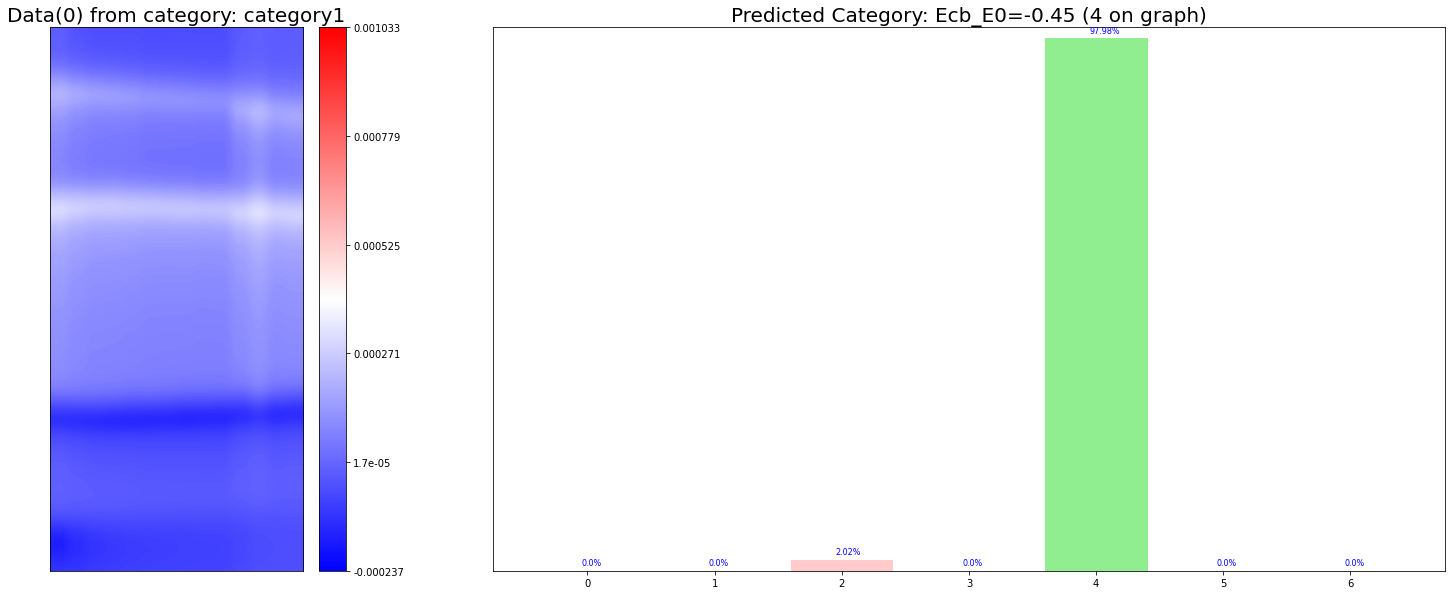

In [ ]:
# TO DO: input i value of data you would like to see and j value of method of displaying
i = 0
j = 2
predictions = model_2.predict(experimental_data)#validation_data

if(j == 0):
  predict_top_three(i,predictions,trn_categories)
elif(j == 1):
  predict_top_three_multiple(i,9,predictions,trn_categories)
elif(j == 2):
  #swaps made: experimental_data -> validation_data, exp_categories-> trn_categories, experimental_category_index -> validation_labels
  display_predictions(i,experimental_data,predictions,trn_categories,exp_categories,exp_categories_index, min_val, max_val)

In [ ]:
print(len(validation_labels))
print(len(exp_categories))

1056
3
